In [73]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt

In [74]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [75]:
def load_data_from_csv(data_path):
    return pd.read_csv(data_path)

In [76]:
MAIN_DIR_PATH = '../01 PM2.5 Chinese Weather data'
cities_data_path_list = os.listdir(MAIN_DIR_PATH)

In [77]:
print(*cities_data_path_list, sep='\n')

BeijingPM20100101_20151231.csv
ChengduPM20100101_20151231.csv
GuangzhouPM20100101_20151231.csv
ShanghaiPM20100101_20151231.csv
ShenyangPM20100101_20151231.csv


Beijing city data analysis

In [78]:
sample_data_path = os.path.join(MAIN_DIR_PATH, cities_data_path_list[0])
print(sample_data_path)
data = load_data_from_csv(sample_data_path)

../01 PM2.5 Chinese Weather data\BeijingPM20100101_20151231.csv


In [79]:
data.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [80]:
data.shape

(52584, 18)

1. DATA ANALYSIS

1.1 Features present in the Beijing dataset

In [81]:
#statistical information about columns
print(data.describe())

                 No          year         month           day          hour  \
count  52584.000000  52584.000000  52584.000000  52584.000000  52584.000000   
mean   26292.500000   2012.499772      6.523962     15.726609     11.500000   
std    15179.837614      1.707485      3.448452      8.798896      6.922252   
min        1.000000   2010.000000      1.000000      1.000000      0.000000   
25%    13146.750000   2011.000000      4.000000      8.000000      5.750000   
50%    26292.500000   2012.000000      7.000000     16.000000     11.500000   
75%    39438.250000   2014.000000     10.000000     23.000000     17.250000   
max    52584.000000   2015.000000     12.000000     31.000000     23.000000   

             season     PM_Dongsi  PM_Dongsihuan  PM_Nongzhanguan  \
count  52584.000000  25052.000000   20508.000000     24931.000000   
mean       2.491100     89.154439      92.560806        88.643737   
std        1.116988     87.239267      88.027434        88.041166   
min        1

In [82]:
#checking how many null values are in each column
data.isnull().sum()

No                     0
year                   0
month                  0
day                    0
hour                   0
season                 0
PM_Dongsi          27532
PM_Dongsihuan      32076
PM_Nongzhanguan    27653
PM_US Post          2197
DEWP                   5
HUMI                 339
PRES                 339
TEMP                   5
cbwd                   5
Iws                    5
precipitation        484
Iprec                484
dtype: int64

In [83]:
# Here are the features we have
for idx, col in enumerate(data.columns):
    print(idx + 1, col)

1 No
2 year
3 month
4 day
5 hour
6 season
7 PM_Dongsi
8 PM_Dongsihuan
9 PM_Nongzhanguan
10 PM_US Post
11 DEWP
12 HUMI
13 PRES
14 TEMP
15 cbwd
16 Iws
17 precipitation
18 Iprec


1.2 Find NaN values columns and analyze them

In [84]:
for col in data.columns:
    if data[col].isnull().any():
        print(col)

PM_Dongsi
PM_Dongsihuan
PM_Nongzhanguan
PM_US Post
DEWP
HUMI
PRES
TEMP
cbwd
Iws
precipitation
Iprec


Our target feature is PM2.5, which we must predict using the LSTM network. But we have rows with NaN PM values. What I decided to do is remove all PM-like columns and create one PM column.
Since we have 4 PM values in each row, firstly we need to find the rows with 4 NAN values in the row and remove them. 
Ex: (PM_Dongsi, PM_Dongsihuan, PM_Nongzhanguan, PM_US Post) == (NaN, NaN, NaN, NaN) ---> remove row

In [85]:
def get_pm_columns(data_frame):
    cols = list(data_frame.columns)
    pm_cols = []
    for col in cols:
        if col.startswith('PM'):
            pm_cols.append(col)
    return pm_cols 

In [86]:
data.shape

(52584, 18)

In [87]:
pm_cols = get_pm_columns(data)
all_nan_pm_rows_indexes = []
(n_rows, n_cols) = data.shape
for idx, (index, row) in enumerate(data.iterrows()):
    if row[pm_cols].isnull().all(): # .all()
        all_nan_pm_rows_indexes.append(index)
    
    if (idx + 1) % 5000 == 0:
        print(idx + 1, ' / ', n_rows)

5000  /  52584
10000  /  52584
15000  /  52584
20000  /  52584
25000  /  52584
30000  /  52584
35000  /  52584
40000  /  52584
45000  /  52584
50000  /  52584


In [88]:
print('Number of all PM NaN rows', len(all_nan_pm_rows_indexes))

Number of all PM NaN rows 1894


I build correlation matrix to check for linear relationship between the variables. The heatmap I generate provides a quick overview of how variables in the dataset relate to one another, which can be very useful for further data analysis or modeling.

In [89]:
import seaborn as sns

# Step 1: Exclude non-numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Step 2: Calculate the correlation matrix for numeric data only
corr = numeric_data.corr()

# Step 3: Styling and visualizing the correlation matrix
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

# Use .format() instead of .set_precision()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magnify")\
    .format(precision=2)\
    .set_table_styles(magnify())

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
No,1.00,0.99,0.17,0.02,0.00,0.03,-0.04,-0.02,-0.02,-0.05,0.07,0.02,-0.01,0.07,-0.06,0.01,0.01
year,0.99,1.00,0.00,-0.00,-0.00,-0.00,-0.03,-0.01,-0.02,-0.05,0.03,-0.02,-0.01,0.05,-0.06,0.01,0.01
month,0.17,0.00,1.00,0.01,0.00,0.21,-0.06,-0.03,-0.03,-0.01,0.25,0.22,-0.05,0.16,0.01,0.01,0.01
day,0.02,-0.00,0.01,1.00,-0.00,-0.01,0.07,0.06,0.07,0.08,0.04,0.04,-0.00,0.02,-0.02,-0.00,-0.00
hour,0.00,-0.00,0.00,-0.00,1.00,-0.00,0.02,-0.03,-0.01,0.00,-0.02,-0.26,-0.04,0.15,0.06,0.00,0.00
season,0.03,-0.00,0.21,-0.01,-0.00,1.00,0.13,0.11,0.17,0.13,-0.42,0.03,0.57,-0.57,0.04,0.00,0.00
PM_Dongsi,-0.04,-0.03,-0.06,0.07,0.02,0.13,1.00,0.93,0.96,0.96,0.10,0.38,0.03,-0.17,-0.22,-0.01,-0.01
PM_Dongsihuan,-0.02,-0.01,-0.03,0.06,-0.03,0.11,0.93,1.00,0.96,0.95,0.10,0.39,0.04,-0.18,-0.23,-0.03,-0.05
PM_Nongzhanguan,-0.02,-0.02,-0.03,0.07,-0.01,0.17,0.96,0.96,1.00,0.97,0.06,0.38,0.07,-0.21,-0.22,-0.01,-0.01
PM_US Post,-0.05,-0.05,-0.01,0.08,0.00,0.13,0.96,0.95,0.97,1.00,0.13,0.42,-0.02,-0.13,-0.24,-0.00,-0.00


Yes. We found the relationship between several variables. 
TEMP and PRES show a strong negative correlation. This suggests that as the temperature increases, pressure tends to decrease, which is a common atmospheric relationship.
There's a moderate positive correlation between DEWP and HUMI. Dew point and humidity are related because both are measures of moisture in the air. A higher dew point indicates more moisture, which generally correlates with higher humidity. However, the relationship is not perfect, as other factors like temperature and pressure also influence humidity.

Since DEWP HUMI PRES TEMP showing good to moderate coorelation between them, they could play a huge role while training the model.
Let us look for any NaN values in these columns.

In [90]:
dhpt_cols = ['DEWP', 'HUMI', 'PRES', 'TEMP']
any_nan_dhpt_rows_indexes = []

for idx, (index, row) in enumerate(data.iterrows()):
    if row[dhpt_cols].isnull().any(): #.any()
        any_nan_dhpt_rows_indexes.append(index)
    
    if (idx + 1) % 5000 == 0:
        print(idx + 1, ' / ', n_rows)

5000  /  52584
10000  /  52584
15000  /  52584
20000  /  52584
25000  /  52584
30000  /  52584
35000  /  52584
40000  /  52584
45000  /  52584
50000  /  52584


In [91]:
print('Number of any of DEWP HUMI PRES TEMP NaN rows', len(any_nan_dhpt_rows_indexes))

Number of any of DEWP HUMI PRES TEMP NaN rows 339


Let us create a single PM column to replace the four PM columns we have for each time stamp

In [92]:
def get_pm_columns(data_frame):
    cols = list(data_frame.columns)
    pm_cols = []
    for col in cols:
        if col.startswith('PM'):
            pm_cols.append(col)
    return pm_cols 

def get_main_features_columns(data_frame):
    cols = list(data_frame.columns)
    features_cols = []
    for col in cols:
        if not col.startswith('PM'):
            features_cols.append(col)
    return features_cols

In [93]:
pm_cols = get_pm_columns(data)
features_columns = get_main_features_columns(data)
features_columns.append('PM')

In [94]:
features_columns

['No',
 'year',
 'month',
 'day',
 'hour',
 'season',
 'DEWP',
 'HUMI',
 'PRES',
 'TEMP',
 'cbwd',
 'Iws',
 'precipitation',
 'Iprec',
 'PM']

In [95]:
# Ensure 'PM' is not in features_columns
features_columns = [col for col in features_columns if col != 'PM']

new_data_rows_list = []
for idx, (index, row) in enumerate(data.iterrows()):
    mn = row[pm_cols].mean()
    if not math.isnan(mn):
        temp_row = {col: row[col] for col in features_columns}
        temp_row['PM'] = mn

        new_data_rows_list.append(temp_row)

    if idx % 1000 == 0 and idx != 0:
        print(idx)

# Convert the list of dictionaries into a DataFrame
new_data = pd.DataFrame(new_data_rows_list)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000


In [96]:
new_data.shape

(50690, 15)

In [97]:
new_data.head()


,No,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,PM
0,24,2010,1,1,23,4,-17.0,41.0,1020.0,-5.0,cv,0.89,0.0,0.0,129.0
1,25,2010,1,2,0,4,-16.0,38.0,1020.0,-4.0,SE,1.79,0.0,0.0,148.0
2,26,2010,1,2,1,4,-15.0,42.0,1020.0,-4.0,SE,2.68,0.0,0.0,159.0
3,27,2010,1,2,2,4,-11.0,63.5,1021.0,-5.0,SE,3.57,0.0,0.0,181.0
4,28,2010,1,2,3,4,-7.0,85.0,1022.0,-5.0,SE,5.36,0.0,0.0,138.0


In [98]:
dhpt_cols = ['DEWP', 'HUMI', 'PRES', 'TEMP']
any_nan_dhpt_rows_indexess = []

for idx, (index, row) in enumerate(new_data.iterrows()):
    if row[dhpt_cols].isnull().any(): #.any()
        any_nan_dhpt_rows_indexess.append(index)
    
    if (idx + 1) % 5000 == 0:
        print(idx + 1, ' / ', n_rows)

5000  /  52584
10000  /  52584
15000  /  52584
20000  /  52584
25000  /  52584
30000  /  52584
35000  /  52584
40000  /  52584
45000  /  52584
50000  /  52584


In [99]:
print('Number of any of DEWP HUMI PRES TEMP NaN rows', len(any_nan_dhpt_rows_indexes))

Number of any of DEWP HUMI PRES TEMP NaN rows 339


We have timestamp information in 4 different columns. We need to covert it into single column and place it in the second column.

In [100]:
new_data['datetime'] = pd.to_datetime(new_data[['year', 'month', 'day', 'hour']])

new_data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

# Reorder columns to place 'datetime' as the second column
# First get the list of columns
columns = list(new_data.columns)

# Place 'datetime' as the second column and keep the rest of the columns in their current order
new_column_order = ['No', 'datetime'] + [col for col in columns if col not in ['No', 'datetime']]

# Reorder DataFrame columns
new_data = new_data[new_column_order]

In [101]:
new_data.head()

,No,datetime,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,PM
0,24,2010-01-01 23:00:00,4,-17.0,41.0,1020.0,-5.0,cv,0.89,0.0,0.0,129.0
1,25,2010-01-02 00:00:00,4,-16.0,38.0,1020.0,-4.0,SE,1.79,0.0,0.0,148.0
2,26,2010-01-02 01:00:00,4,-15.0,42.0,1020.0,-4.0,SE,2.68,0.0,0.0,159.0
3,27,2010-01-02 02:00:00,4,-11.0,63.5,1021.0,-5.0,SE,3.57,0.0,0.0,181.0
4,28,2010-01-02 03:00:00,4,-7.0,85.0,1022.0,-5.0,SE,5.36,0.0,0.0,138.0


In [102]:
new_data.isnull().sum()

No                 0
datetime           0
season             0
DEWP               5
HUMI             339
PRES             339
TEMP               5
cbwd               5
Iws                5
precipitation    484
Iprec            484
PM                 0
dtype: int64

Let us plot PM against datetime to understand the nature of PM through the all timestamps.

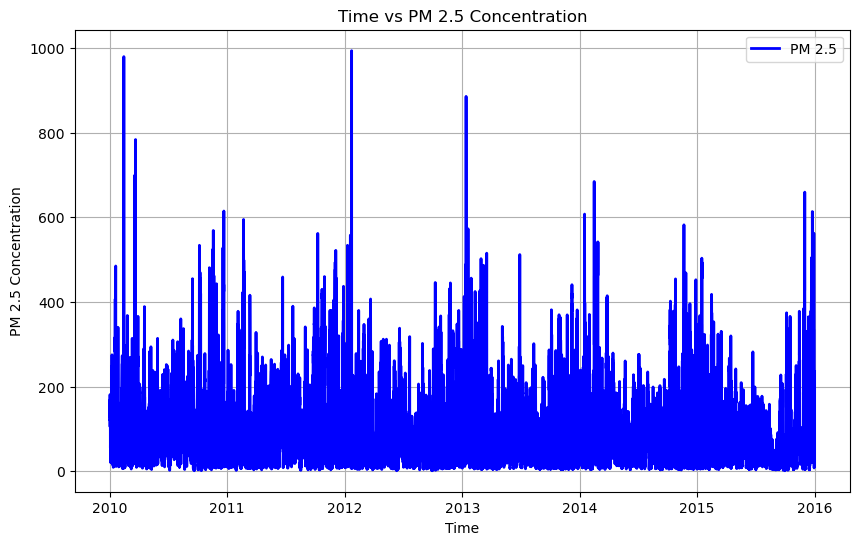

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(new_data['datetime'], new_data['PM'], label='PM 2.5', color='b', linewidth=2)
plt.xlabel('Time')
plt.ylabel('PM 2.5 Concentration')
plt.title('Time vs PM 2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()

Let us plot PM against each year seperately to understand it in more detail.

[2010 2011 2012 2013 2014 2015]


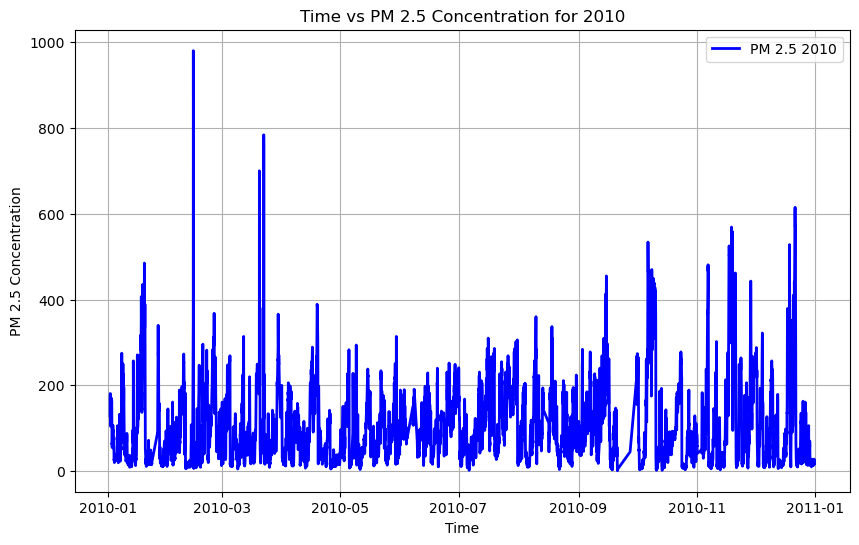

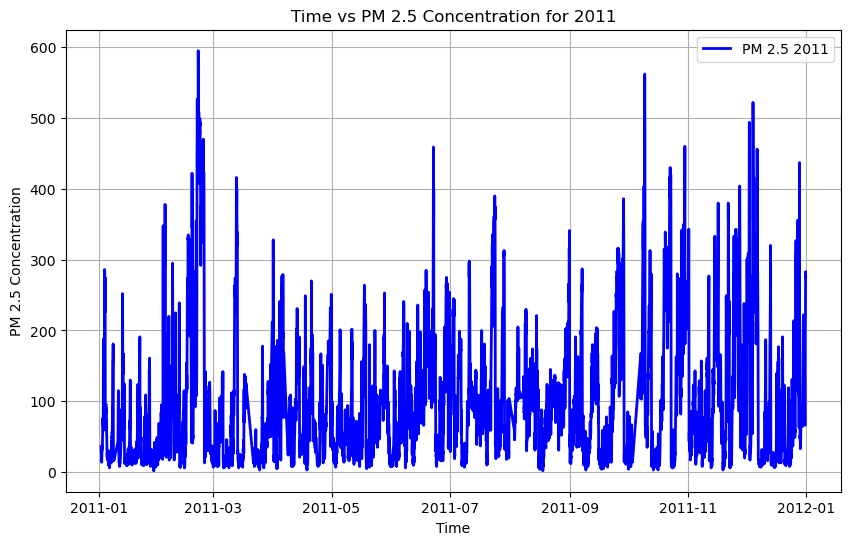

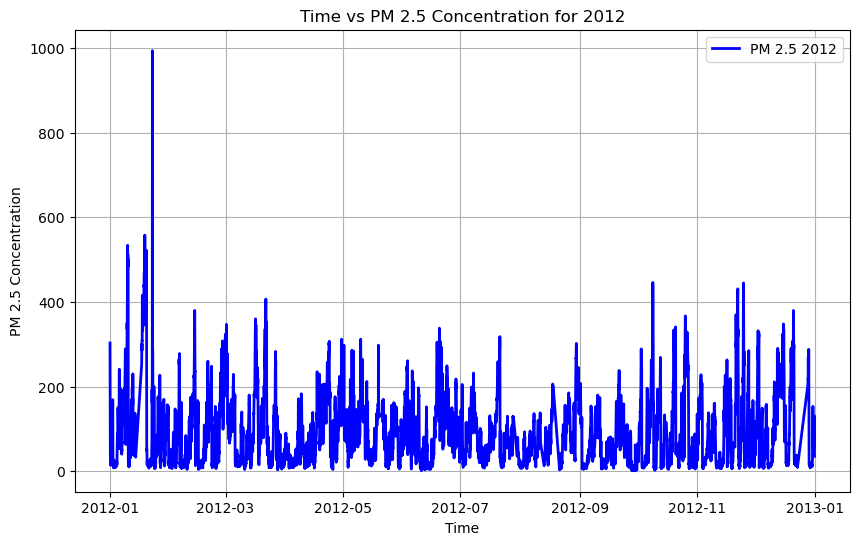

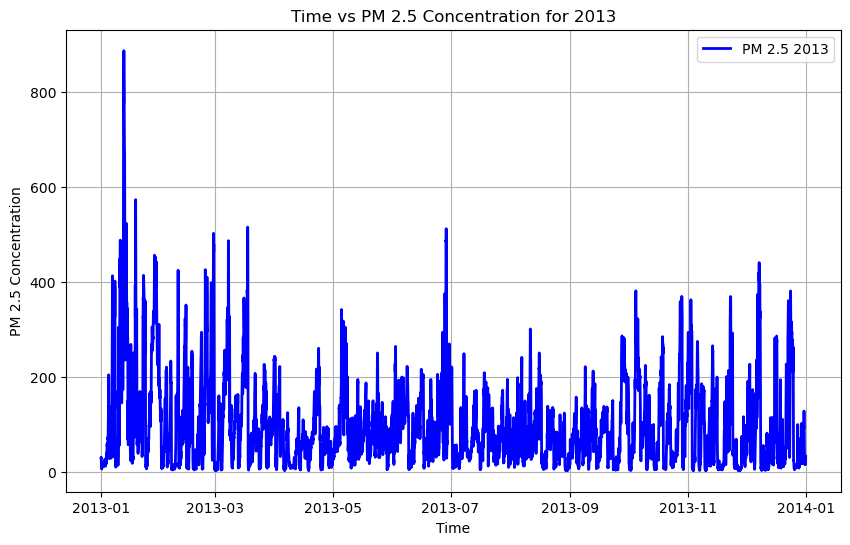

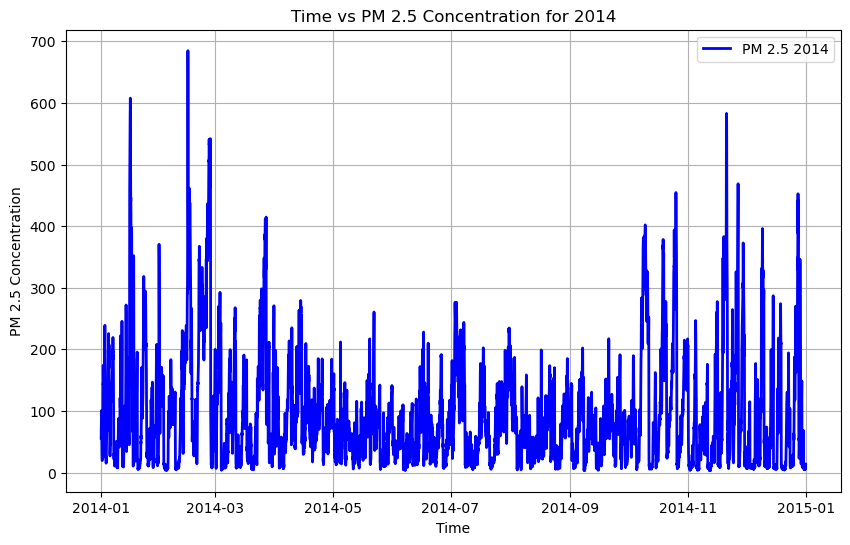

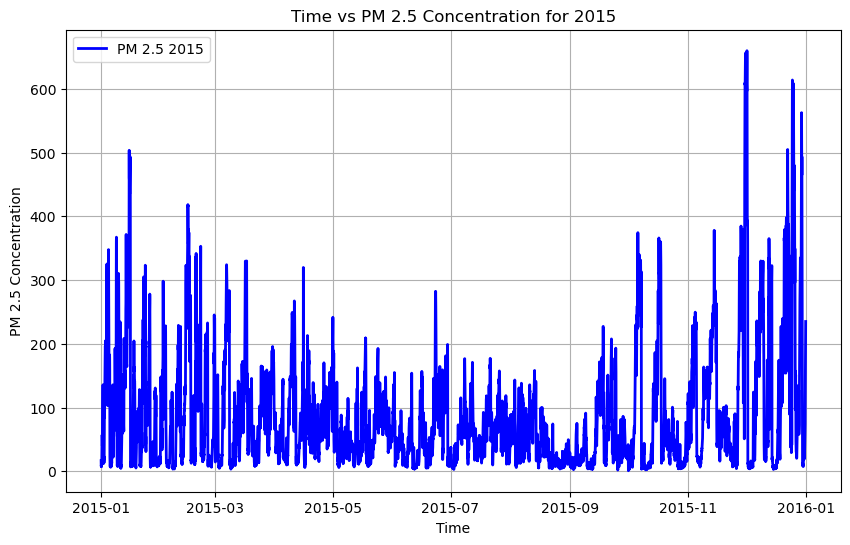

In [104]:
# Define the range of years you want to plot
years = new_data['datetime'].dt.year.unique()
print(years)

# Create a plot for each year
for year in years:
    subset_data = new_data[new_data['datetime'].dt.year == year]
    
    plt.figure(figsize=(10, 6))
    plt.plot(subset_data['datetime'], subset_data['PM'], label=f'PM 2.5 {year}', color='b', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('PM 2.5 Concentration')
    plt.title(f'Time vs PM 2.5 Concentration for {year}')
    plt.legend()
    plt.grid(True)
    plt.show()